In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow import keras
from PIL import Image
import os
import pathlib
import random as rn
from sklearn.model_selection import train_test_split
import tensorflow_hub as hub
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, array_to_img, load_img
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
from keras.models import load_model
from sklearn.metrics import accuracy_score

Init Plugin
Init Graph Optimizer
Init Kernel


In [2]:
train = '/Users/ebenafrifa/Documents/machine_vision/GTSRB/Training/Images'
test_path = '/Users/ebenafrifa/Documents/machine_vision/GTSRB/Test/Images'
height = 50
width = 50

In [3]:
classes = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)', 
            2:'Speed limit (50km/h)', 
            3:'Speed limit (60km/h)', 
            4:'Speed limit (70km/h)', 
            5:'Speed limit (80km/h)', 
            6:'End of speed limit (80km/h)', 
            7:'Speed limit (100km/h)', 
            8:'Speed limit (120km/h)', 
            9:'No passing', 
            10:'No passing veh over 3.5 tons', 
            11:'Right-of-way at intersection', 
            12:'Priority road', 
            13:'Yield', 
            14:'Stop', 
            15:'No vehicles', 
            16:'Veh > 3.5 tons prohibited', 
            17:'No entry', 
            18:'General caution', 
            19:'Dangerous curve left', 
            20:'Dangerous curve right', 
            21:'Double curve', 
            22:'Bumpy road', 
            23:'Slippery road', 
            24:'Road narrows on the right', 
            25:'Road work', 
            26:'Traffic signals', 
            27:'Pedestrians', 
            28:'Children crossing', 
            29:'Bicycles crossing', 
            30:'Beware of ice/snow',
            31:'Wild animals crossing', 
            32:'End speed + passing limits', 
            33:'Turn right ahead', 
            34:'Turn left ahead', 
            35:'Ahead only', 
            36:'Go straight or right', 
            37:'Go straight or left', 
            38:'Keep right', 
            39:'Keep left', 
            40:'Roundabout mandatory', 
            41:'End of no passing', 
            42:'End no passing veh > 3.5 tons' }

In [4]:
batch_size = 300
seed = 42

In [5]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   validation_split=0.2)
train_dataset = train_datagen.flow_from_directory(train,
                                                  target_size=(height, width),
                                                  batch_size=batch_size,
                                                  class_mode='categorical',
                                                  shuffle=True,
                                                  seed=seed,
                                                  color_mode='rgb',
                                                  interpolation='hamming',
                                                  subset='training')

test_datagen = ImageDataGenerator(rescale=1./255,
                                  validation_split=0.2)
test_dataset = test_datagen.flow_from_directory(train,
                                                target_size=(height, width),
                                                batch_size=batch_size,
                                                class_mode='categorical',
                                                shuffle=True,
                                                seed=seed,
                                                color_mode='rgb',
                                                interpolation='hamming',
                                                subset='validation')

Found 31368 images belonging to 43 classes.
Found 7841 images belonging to 43 classes.


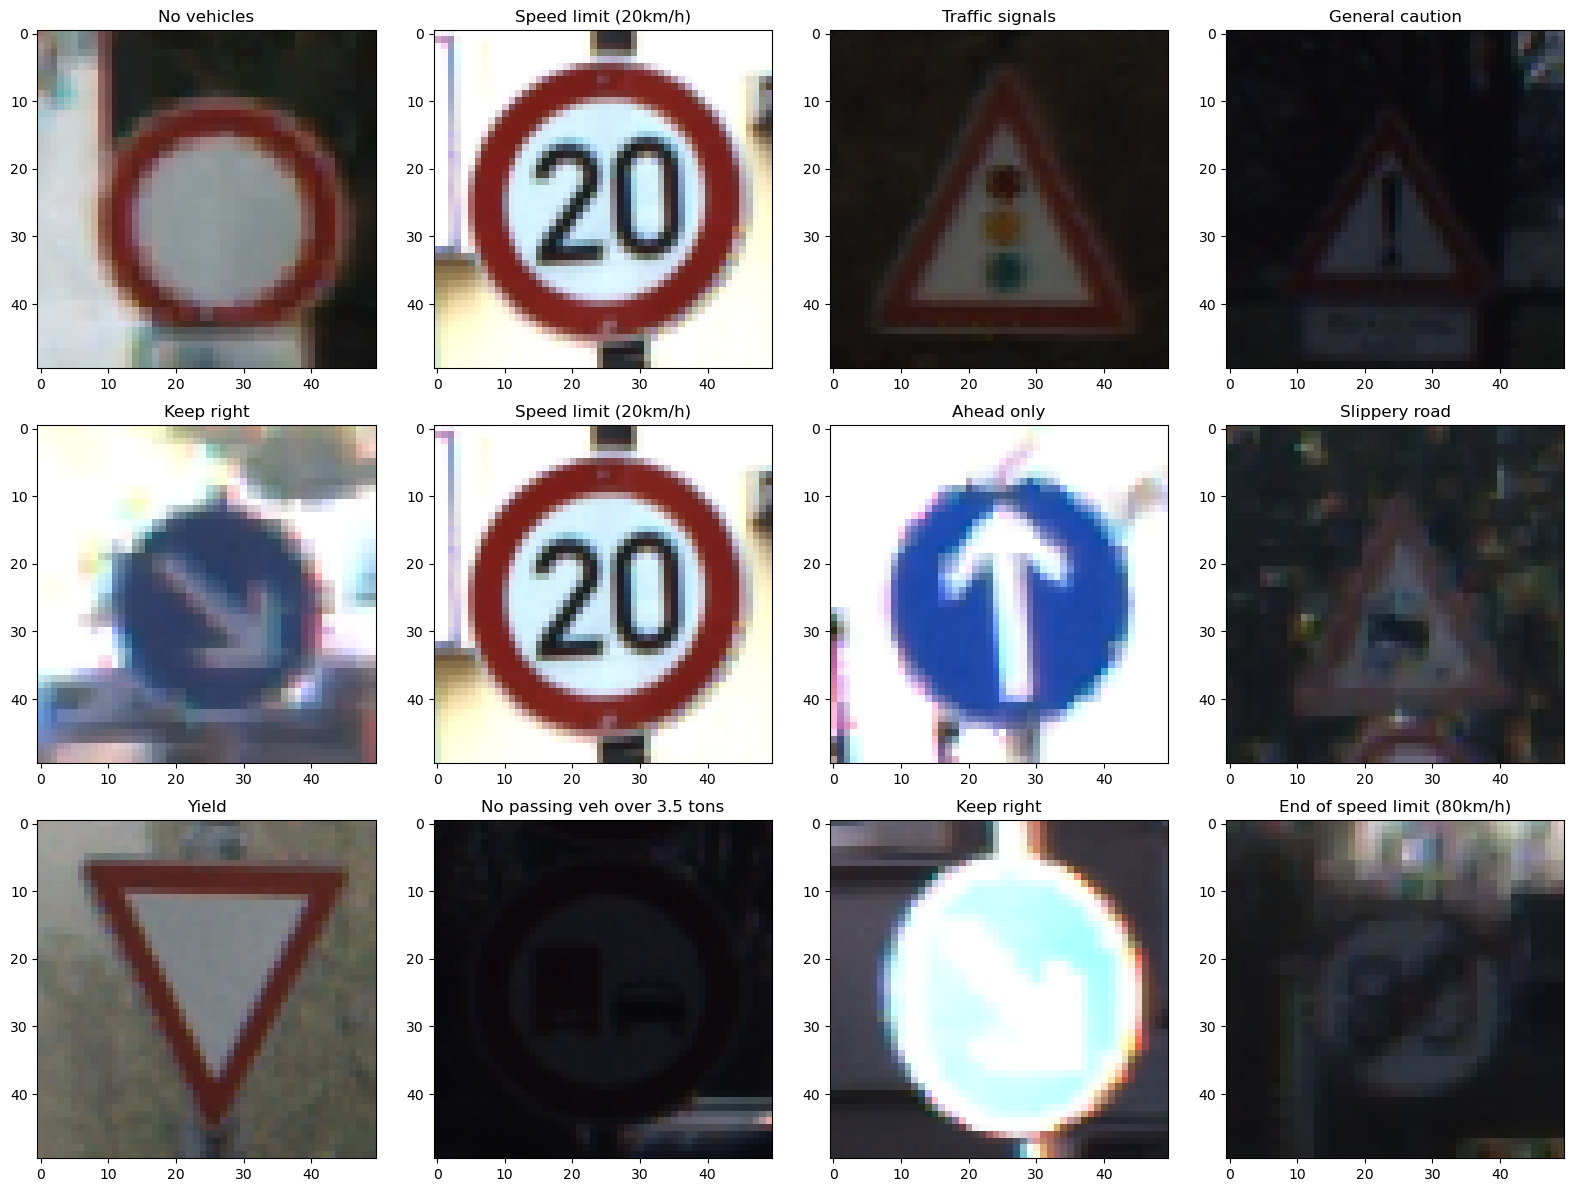

In [6]:
fig,ax=plt.subplots(3,4)
fig.set_size_inches(16,12)
img,y = train_dataset.next()
for i in range(3):
    for j in range (4):
        l=rn.randint(0,batch_size-1)
        label = classes[int(list(train_dataset.class_indices.keys())[np.argmax(y[l])])]
        ax[i,j].imshow(img[l])
        ax[i,j].set_title(label)

plt.tight_layout()

In [7]:
model = keras.models.Sequential([    
    keras.layers.Conv2D(filters=16, kernel_size=(5,5), activation='relu', input_shape=(height,width,3)),
    keras.layers.Conv2D(filters=32, kernel_size=(5,5), activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(axis=-1),
    
    keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(axis=-1),
    keras.layers.Dropout(rate=0.25),
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(rate=0.25),
    
    keras.layers.Dense(43, activation='softmax')
])
model.summary()

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2022-11-30 16:44:35.474362: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-11-30 16:44:35.474476: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 46, 46, 16)        1216      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 42, 42, 32)        12832     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 21, 21, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 21, 21, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 19, 19, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 17, 17, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 64)          0

In [8]:
alpha=0.01
epochs=10
optim = keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer = optim, loss = 'categorical_crossentropy', metrics = ['accuracy'])


In [9]:
history = model.fit(train_dataset,
                    steps_per_epoch=len(train_dataset),
                    epochs=epochs,
                    validation_data=test_dataset,
                    validation_steps=len(test_dataset))

Epoch 1/10


2022-11-30 16:44:35.904143: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-11-30 16:44:35.904350: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-11-30 16:44:36.135147: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


105/105 [==============================] - ETA: 0s - loss: 0.7797 - accuracy: 0.8036

2022-11-30 16:44:48.079907: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


105/105 [==============================] - 14s 102ms/step - loss: 0.7797 - accuracy: 0.8036 - val_loss: 1.2699 - val_accuracy: 0.7197
Epoch 2/10
105/105 [==============================] - 8s 80ms/step - loss: 0.0523 - accuracy: 0.9850 - val_loss: 0.3034 - val_accuracy: 0.9126
Epoch 3/10
105/105 [==============================] - 8s 77ms/step - loss: 0.0209 - accuracy: 0.9935 - val_loss: 0.4521 - val_accuracy: 0.8896
Epoch 4/10
105/105 [==============================] - 8s 77ms/step - loss: 0.0159 - accuracy: 0.9951 - val_loss: 0.2212 - val_accuracy: 0.9477
Epoch 5/10
105/105 [==============================] - 8s 76ms/step - loss: 0.0137 - accuracy: 0.9954 - val_loss: 1.4395 - val_accuracy: 0.7336
Epoch 6/10
105/105 [==============================] - 8s 75ms/step - loss: 0.0179 - accuracy: 0.9940 - val_loss: 0.4934 - val_accuracy: 0.8938
Epoch 7/10
105/105 [==============================] - 8s 75ms/step - loss: 0.0234 - accuracy: 0.9933 - val_loss: 0.5543 - val_accuracy: 0.8952
Epoch 8/

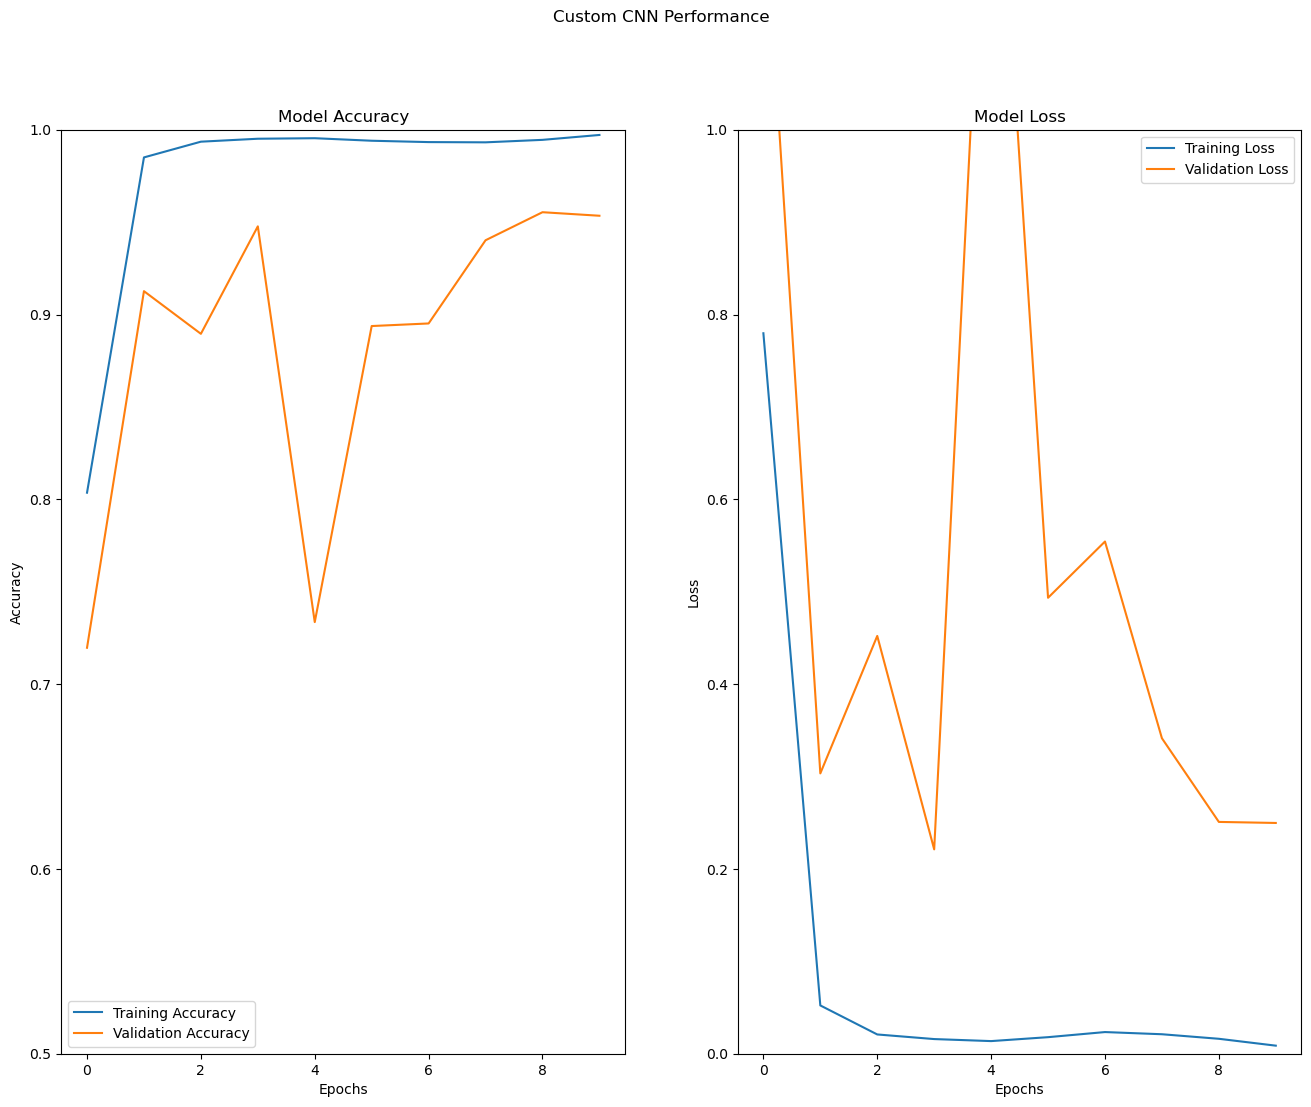

<Figure size 1000x700 with 0 Axes>

In [10]:
fig,ax=plt.subplots(1,2)
fig.set_size_inches(16,12)
performance = pd.DataFrame(history.history)
plt.figure(figsize=(10,7))
ax[1].plot(performance[['loss','val_loss']])
ax[1].legend(['Training Loss', 'Validation Loss'])
ax[1].set_title('Model Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].set_ylim(0,1)
ax[0].plot(performance[['accuracy','val_accuracy']])
ax[0].legend(['Training Accuracy', 'Validation Accuracy'])
ax[0].set_title('Model Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].set_ylim(0.5,1)
fig.suptitle('Custom CNN Performance')
plt.show()

**MobileNets**

In [11]:
base_model = tf.keras.applications.MobileNetV2(input_shape = (height, width, 3), include_top = False, weights = "imagenet")
base_model.trainable = False

In [12]:
mob_model = tf.keras.Sequential([base_model,
                                   keras.layers.GlobalAveragePooling2D(),
                                   keras.layers.Dropout(0.2),
                                   keras.layers.Dense(512, activation='relu'),
                                   keras.layers.BatchNormalization(),
                                   keras.layers.Dropout(rate=0.2),
                                   keras.layers.Dense(43, activation='softmax')                                    
                                ])
mob_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 2, 2, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               655872    
_________________________________________________________________
batch_normalization_3 (Batch (None, 512)               2048      
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 43)               

In [13]:
alpha=0.01
epochs=5
optim = keras.optimizers.Adam(learning_rate=alpha)
mob_model.compile(optimizer = optim, loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [14]:
mob_history = mob_model.fit(train_dataset,
                          steps_per_epoch=len(train_dataset),
                          epochs=epochs,
                          validation_data=test_dataset,
                          validation_steps=len(test_dataset))


Epoch 1/5


2022-11-30 16:46:01.785639: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


105/105 [==============================] - ETA: 0s - loss: 1.3608 - accuracy: 0.5907

2022-11-30 16:46:09.608172: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


105/105 [==============================] - 11s 83ms/step - loss: 1.3608 - accuracy: 0.5907 - val_loss: 2.1868 - val_accuracy: 0.4334
Epoch 2/5
105/105 [==============================] - 7s 70ms/step - loss: 0.7859 - accuracy: 0.7364 - val_loss: 2.1556 - val_accuracy: 0.4740
Epoch 3/5
105/105 [==============================] - 7s 62ms/step - loss: 0.6478 - accuracy: 0.7802 - val_loss: 2.1813 - val_accuracy: 0.4728
Epoch 4/5
105/105 [==============================] - 7s 62ms/step - loss: 0.5590 - accuracy: 0.8094 - val_loss: 2.3311 - val_accuracy: 0.4823
Epoch 5/5
105/105 [==============================] - 7s 63ms/step - loss: 0.4903 - accuracy: 0.8325 - val_loss: 2.3346 - val_accuracy: 0.4809


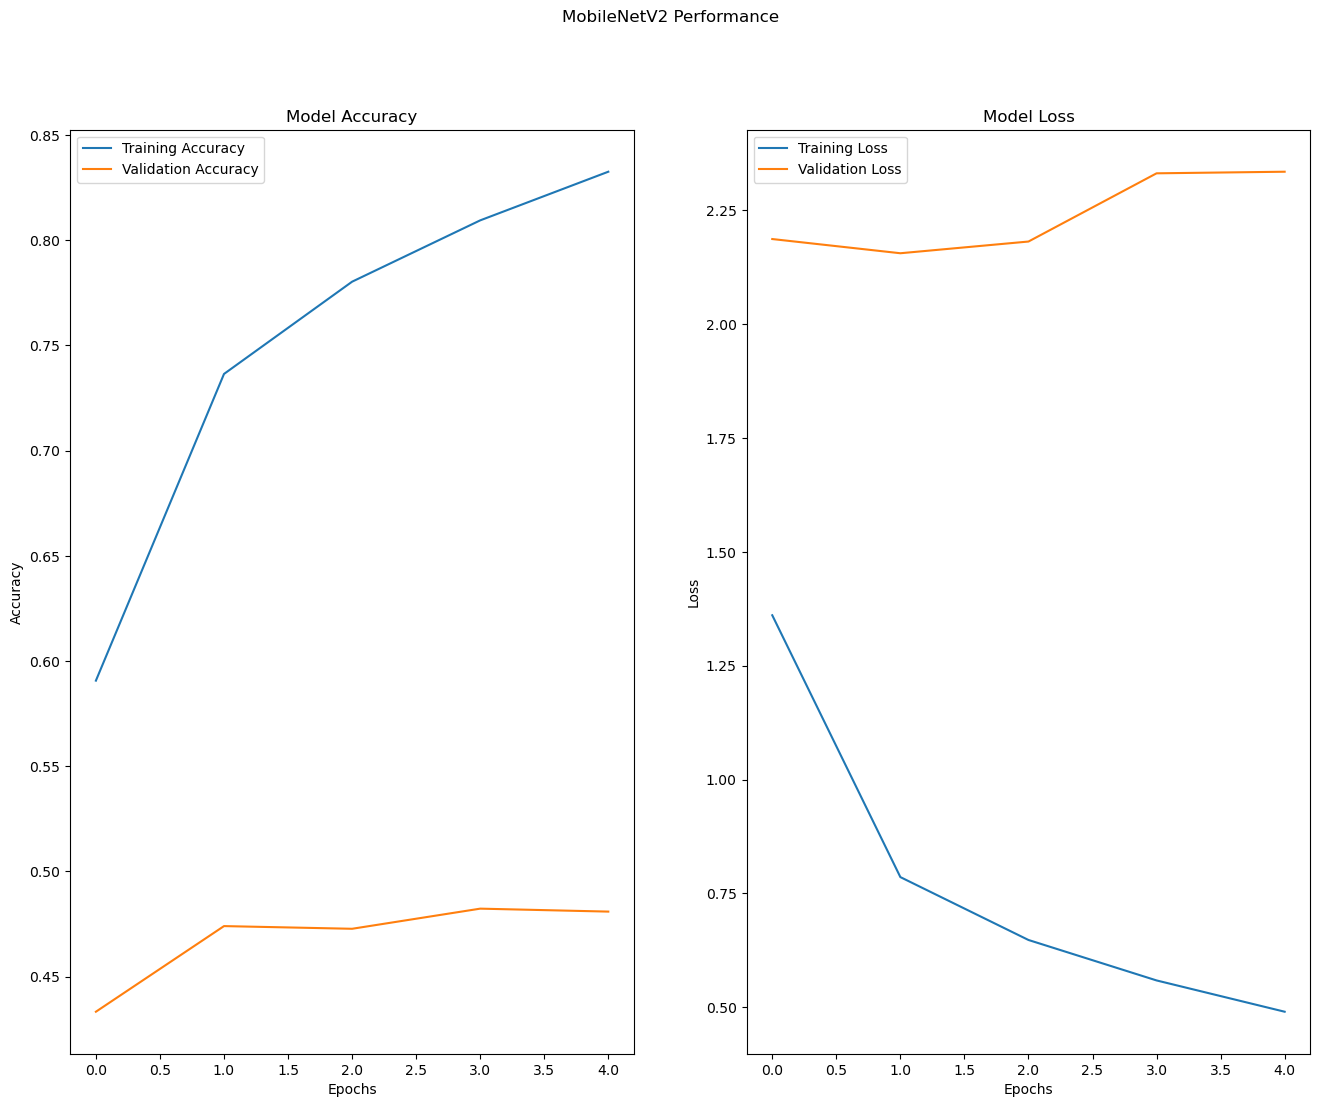

<Figure size 1000x700 with 0 Axes>

In [15]:
fig,ax=plt.subplots(1,2)
fig.set_size_inches(16,12)
performance = pd.DataFrame(mob_history.history)
plt.figure(figsize=(10,7))
ax[1].plot(performance[['loss','val_loss']])
ax[1].legend(['Training Loss', 'Validation Loss'])
ax[1].set_title('Model Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
# ax[1].set_ylim(0,1)
ax[0].plot(performance[['accuracy','val_accuracy']])
ax[0].legend(['Training Accuracy', 'Validation Accuracy'])
ax[0].set_title('Model Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
# ax[0].set_ylim(0.5,1)
fig.suptitle('MobileNetV2 Performance')
plt.show()

In [16]:
# def map_pred(pred):
#     return [int(list(train_dataset.class_indices.keys())[i]) for i in pred]
# test_df = pd.read_csv( test_path + '/Test.csv')

# test_labels = test_df["ClassId"].values
# imgs = test_df["Path"].values

# data =[]

# for img in imgs:
#     try:
#         image = cv2.imread(data_dir +img)
#         image_fromarray = Image.fromarray(image, 'RGB')
#         resize_image = image_fromarray.resize((height, width))
#         data.append(np.array(resize_image))
#     except:
#         print("Error in " + img)
# X_test = np.array(data)
# X_test = X_test/255



In [17]:
vgg_model = tf.keras.Sequential([VGG19(weights='imagenet', include_top=False, input_shape=(height,width,3)),
                                 keras.layers.BatchNormalization(),
                                 keras.layers.Flatten(),
                                 keras.layers.Dense(512, activation='sigmoid'),
                                 keras.layers.Dense(43, activation='softmax')
                                ])

vgg_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 1, 1, 512)         20024384  
_________________________________________________________________
batch_normalization_4 (Batch (None, 1, 1, 512)         2048      
_________________________________________________________________
flatten_1 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_5 (Dense)              (None, 43)                22059     
Total params: 20,311,147
Trainable params: 20,310,123
Non-trainable params: 1,024
_________________________________________________________________


In [18]:
alpha=0.0001
epochs=10
optim = keras.optimizers.Adam(learning_rate=alpha)
vgg_model.compile(optimizer = optim, loss = 'categorical_crossentropy', metrics = ['accuracy'])


In [19]:
vgg_history = vgg_model.fit(train_dataset,
                        steps_per_epoch=len(train_dataset),
                        epochs=epochs,
                        validation_data=test_dataset,
                        validation_steps=len(test_dataset))

Epoch 1/8


2022-11-30 16:46:39.992869: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


105/105 [==============================] - ETA: 0s - loss: 1.1727 - accuracy: 0.7467

2022-11-30 16:47:50.580828: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


105/105 [==============================] - 76s 713ms/step - loss: 1.1727 - accuracy: 0.7467 - val_loss: 1.3489 - val_accuracy: 0.9439
Epoch 2/8
105/105 [==============================] - 74s 704ms/step - loss: 0.0952 - accuracy: 0.9940 - val_loss: 0.5605 - val_accuracy: 0.9413
Epoch 3/8
105/105 [==============================] - 74s 703ms/step - loss: 0.0406 - accuracy: 0.9972 - val_loss: 0.1630 - val_accuracy: 0.9802
Epoch 4/8
105/105 [==============================] - 74s 702ms/step - loss: 0.0202 - accuracy: 0.9991 - val_loss: 0.1234 - val_accuracy: 0.9695
Epoch 5/8
105/105 [==============================] - 74s 703ms/step - loss: 0.0114 - accuracy: 0.9998 - val_loss: 0.0581 - val_accuracy: 0.9870
Epoch 6/8
105/105 [==============================] - 74s 709ms/step - loss: 0.0081 - accuracy: 1.0000 - val_loss: 0.0558 - val_accuracy: 0.9864
Epoch 7/8
105/105 [==============================] - 75s 711ms/step - loss: 0.0064 - accuracy: 1.0000 - val_loss: 0.0534 - val_accuracy: 0.9871
Ep

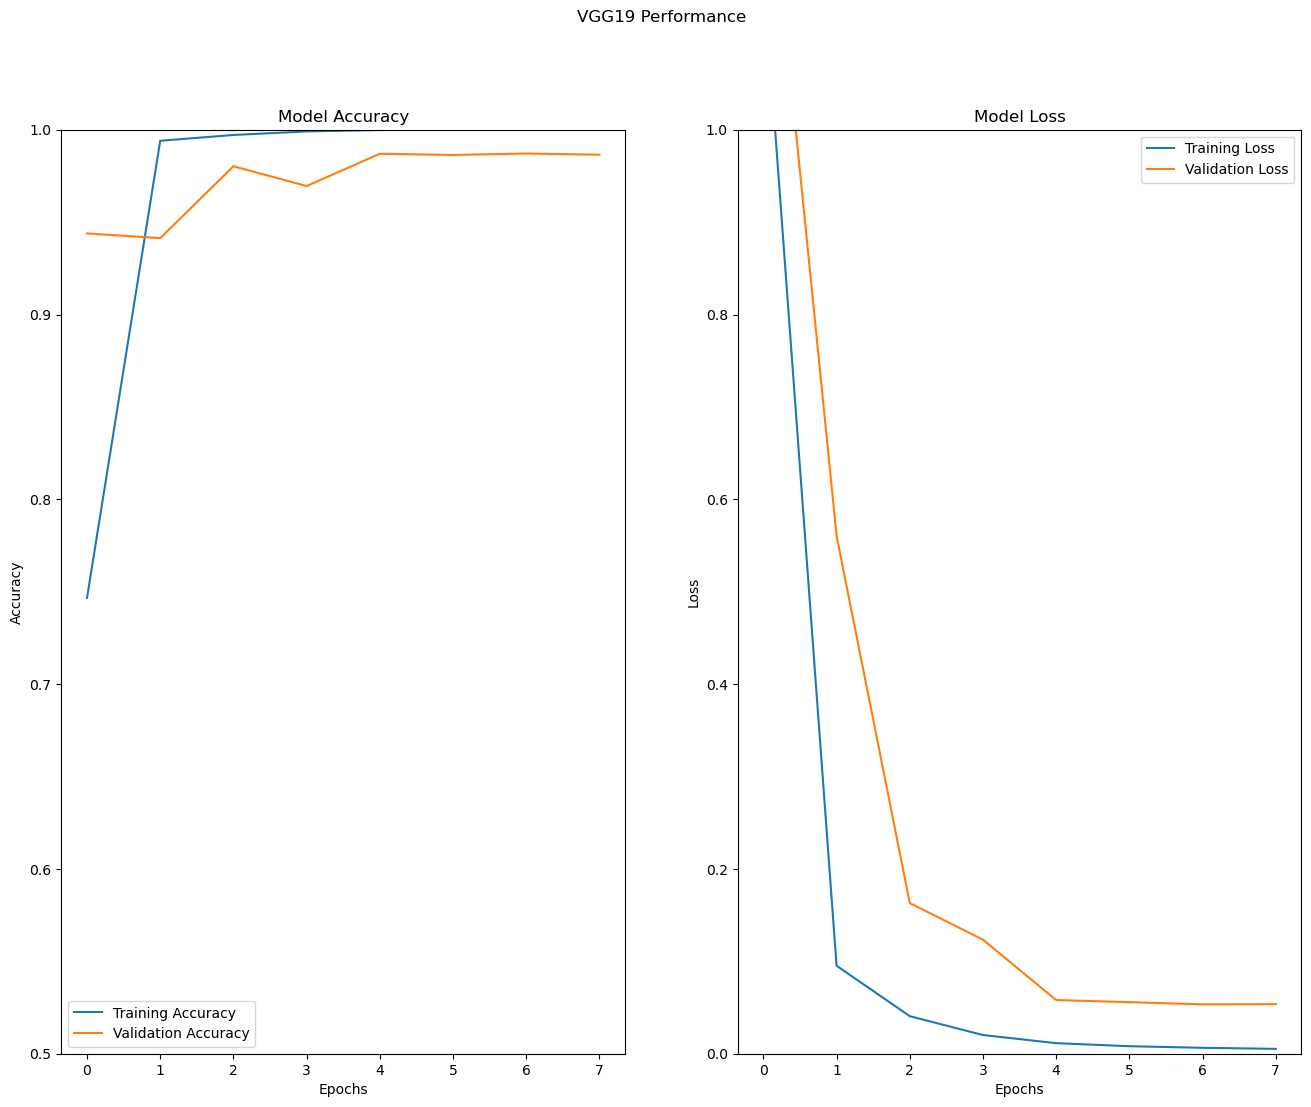

<Figure size 1000x700 with 0 Axes>

In [20]:
fig,ax=plt.subplots(1,2)
fig.set_size_inches(16,12)
performance = pd.DataFrame(vgg_history.history)
plt.figure(figsize=(10,7))
ax[1].plot(performance[['loss','val_loss']])
ax[1].legend(['Training Loss', 'Validation Loss'])
ax[1].set_title('Model Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].set_ylim(0,1)
ax[0].plot(performance[['accuracy','val_accuracy']])
ax[0].legend(['Training Accuracy', 'Validation Accuracy'])
ax[0].set_title('Model Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].set_ylim(0.5,1)
fig.suptitle('VGG19 Performance')
plt.show()